In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from zipfile import ZipFile
from collections import Counter
import seaborn as sns
%matplotlib inline



# Reading data 

In [3]:
with ZipFile('/content/drive/MyDrive/ydata/house-prices-regression-predictions-ydata.zip', 'r') as zObject:
  zObject.extractall(
        path="/content/sample_data/data/")

In [4]:
train_data = pd.read_csv("/content/sample_data/data/train.csv")
test_data = pd.read_csv("/content/sample_data/data/test.csv")

# EDA

## Missing values 

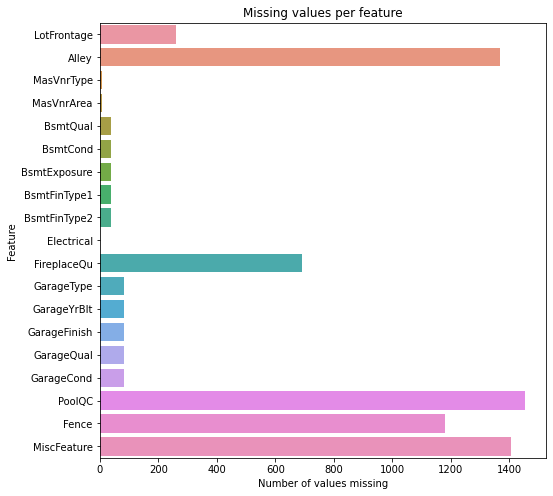

In [5]:
missing_values = train_data.isna().sum(axis=0)
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(8,8))
sns.barplot(y=missing_values.keys(), x=missing_values.values)
plt.title("Missing values per feature")
plt.xlabel("Number of values missing")
plt.ylabel("Feature");


## Fill missing values

In [6]:
MISSING_VALUES_FEATURES = ['PoolQC', 'Alley', 'FireplaceQu', 'Fence', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                           'GarageType','GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
def fill_missing_values(df):
  df_fill = df.copy()
  df_fill[MISSING_VALUES_FEATURES] = df_fill.loc[:, MISSING_VALUES_FEATURES].fillna("NA")
  df_fill[['LotFrontage', 'MasVnrArea']] = df_fill[['LotFrontage', 'MasVnrArea']].fillna(0.0)
  df_fill['MasVnrType'] = df_fill['MasVnrType'].fillna('None')
  # fill electrical missing values with most common value
  df_fill['Electrical'] = df_fill['Electrical'].fillna('SBrkr')
  return df_fill

train_fill = fill_missing_values(train_data)

In [7]:
CATEGORICAL_FEATURES = ['MSZoning','Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                        'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition','RoofStyle','RoofMatl',
                        'MSSubClass', 'OverallCond', 'Exterior1st','Exterior2nd', 'Fireplaces', 'GarageCars', 'MoSold','GarageYrBlt']

NUMERIC_FEATURES = ['LotFrontage','MasVnrArea', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotRmsAbvGrd', 'OverallQual', 'BedroomAbvGr', 'KitchenAbvGr',
                    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                    '3SsnPorch', 'ScreenPorch', 'MiscVal', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'YrSold', 'YearBuilt', 'YearRemodAdd',
                    'SalePrice']

DROP_FEATURES = ['Id']

TARGET = 'SalePrice'


## plot house quality features

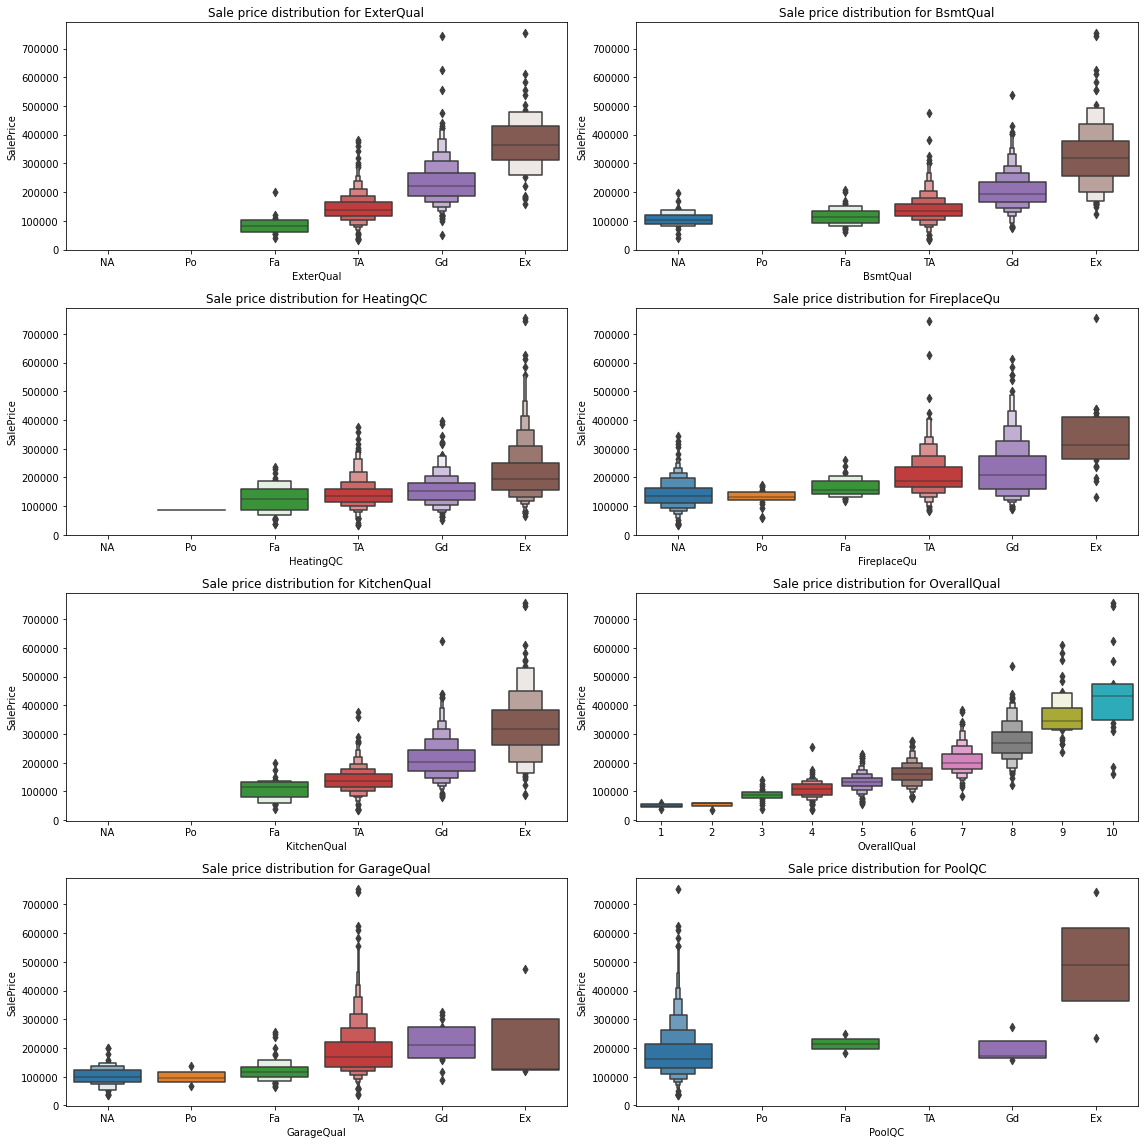

In [8]:
QUALITY_FEATURES = ['ExterQual', 'BsmtQual', 'HeatingQC', 'FireplaceQu', 'KitchenQual', 'OverallQual', 'GarageQual', 'PoolQC']

QUALITY_ORDER = ["NA","Po", "Fa", "TA", "Gd", "Ex"]
fig, ax = plt.subplots(4,2,figsize=(16,16))

for index in range(len(QUALITY_FEATURES)):
  plt.subplot(4,2,index+1)
  feature_name = QUALITY_FEATURES[index]
  plot_order = None
  if len(set(QUALITY_ORDER) & set(train_fill[feature_name].values)) > 0:
    plot_order = QUALITY_ORDER
  sns.boxenplot(data=train_fill, x=feature_name, y='SalePrice', order=plot_order)
  plt.title(f"Sale price distribution for {feature_name}", fontsize=12)

plt.tight_layout()

We can see that some of the house quality features as good information about the house sale price. The features that looks like have good releation to the house price are ExterQual, BsmtQual, KitchenQua and OverallQual.

We can see that most of the houses there is no pool.
For some of the features there is partial relation between the quality to the house price, for example for HeatingQC the sale price is high more houses with excellent quality, but for the other qualites the sale price don't change to much.

For GarageQual, FireplaceQu there is good releation if we split the quality to beteer than Fair quality.

 We can also see that for many quality features on the training data does not contains poor quality.

In [9]:
AGGREGATE_FEATURES= ['GarageQual', "HeatingQC", "FireplaceQu"]

def quality_aggregate_mapping(quality_feature):
  if quality_feature in ['Ex', "Gd", "Ta"]:
    return True

  return False

aggregated_features = train_fill.loc[:, AGGREGATE_FEATURES].copy()
for feature in aggregated_features:
  aggregated_features[feature] = aggregated_features[feature].map(quality_aggregate_mapping)

aggregated_features['SalePrice'] = train_fill['SalePrice']

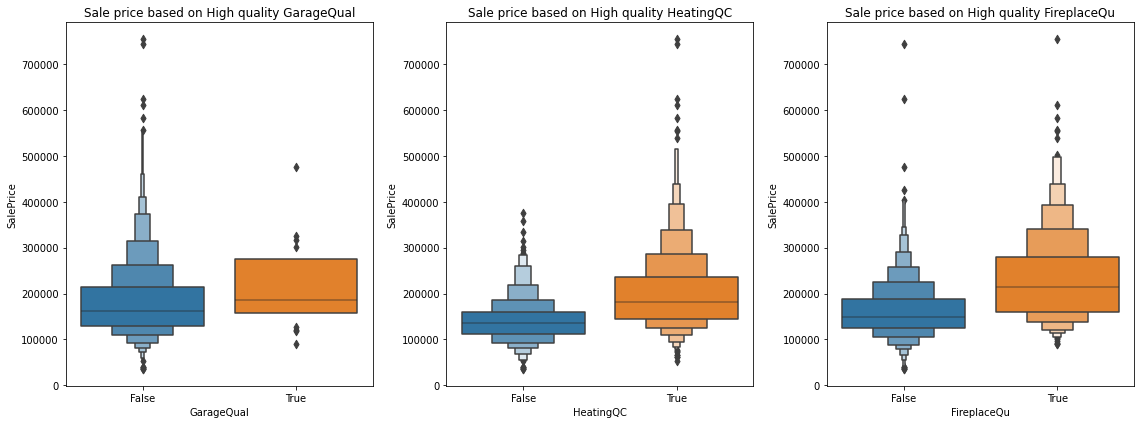

In [10]:
fig, ax = plt.subplots(1,3,figsize=(16,6))

for index in range(len(AGGREGATE_FEATURES)):
  plt.subplot(1,3,index+1)
  feature_name = AGGREGATE_FEATURES[index]
  sns.boxenplot(data=aggregated_features, x=feature_name, y='SalePrice')
  plt.title(f"Sale price based on High quality {feature_name}", fontsize=12)

plt.tight_layout();


We can see that for HeatingQC and FireplaceQu this aggregation looks good

## Other nice categorical features

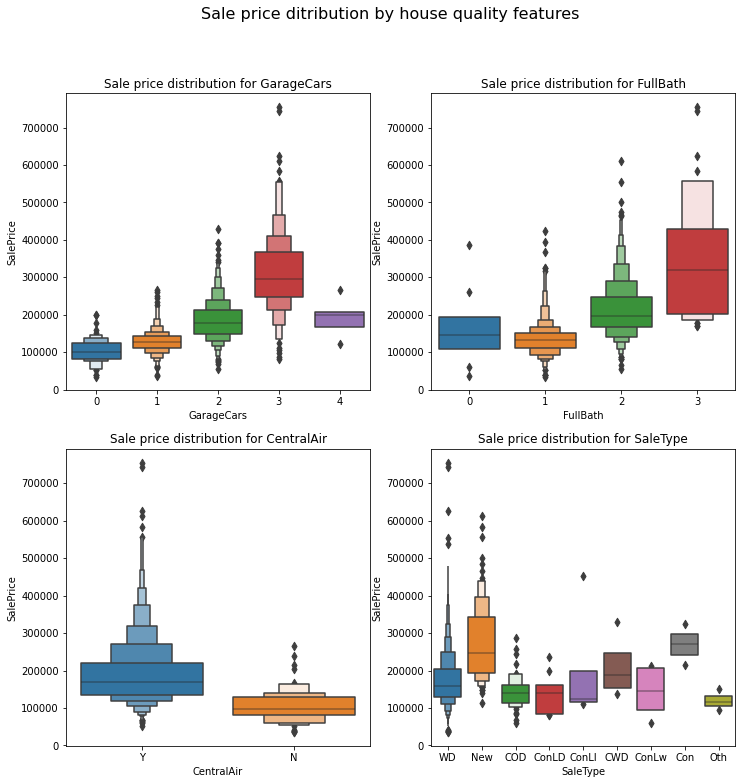

In [11]:
IMPORTANT_FEATURES =  ['GarageCars',  'FullBath', 'CentralAir', 'SaleType']


fig, ax = plt.subplots(2,2,figsize=(12,12))

for index in range(len(IMPORTANT_FEATURES)):
  plt.subplot(2,2,index+1)
  feature_name = IMPORTANT_FEATURES[index]
  sns.boxenplot(data=train_fill, x=feature_name, y='SalePrice')
  plt.title(f"Sale price distribution for {feature_name}", fontsize=12)

fig.suptitle("Sale price ditribution by house quality features", fontsize=16);

## Correlation

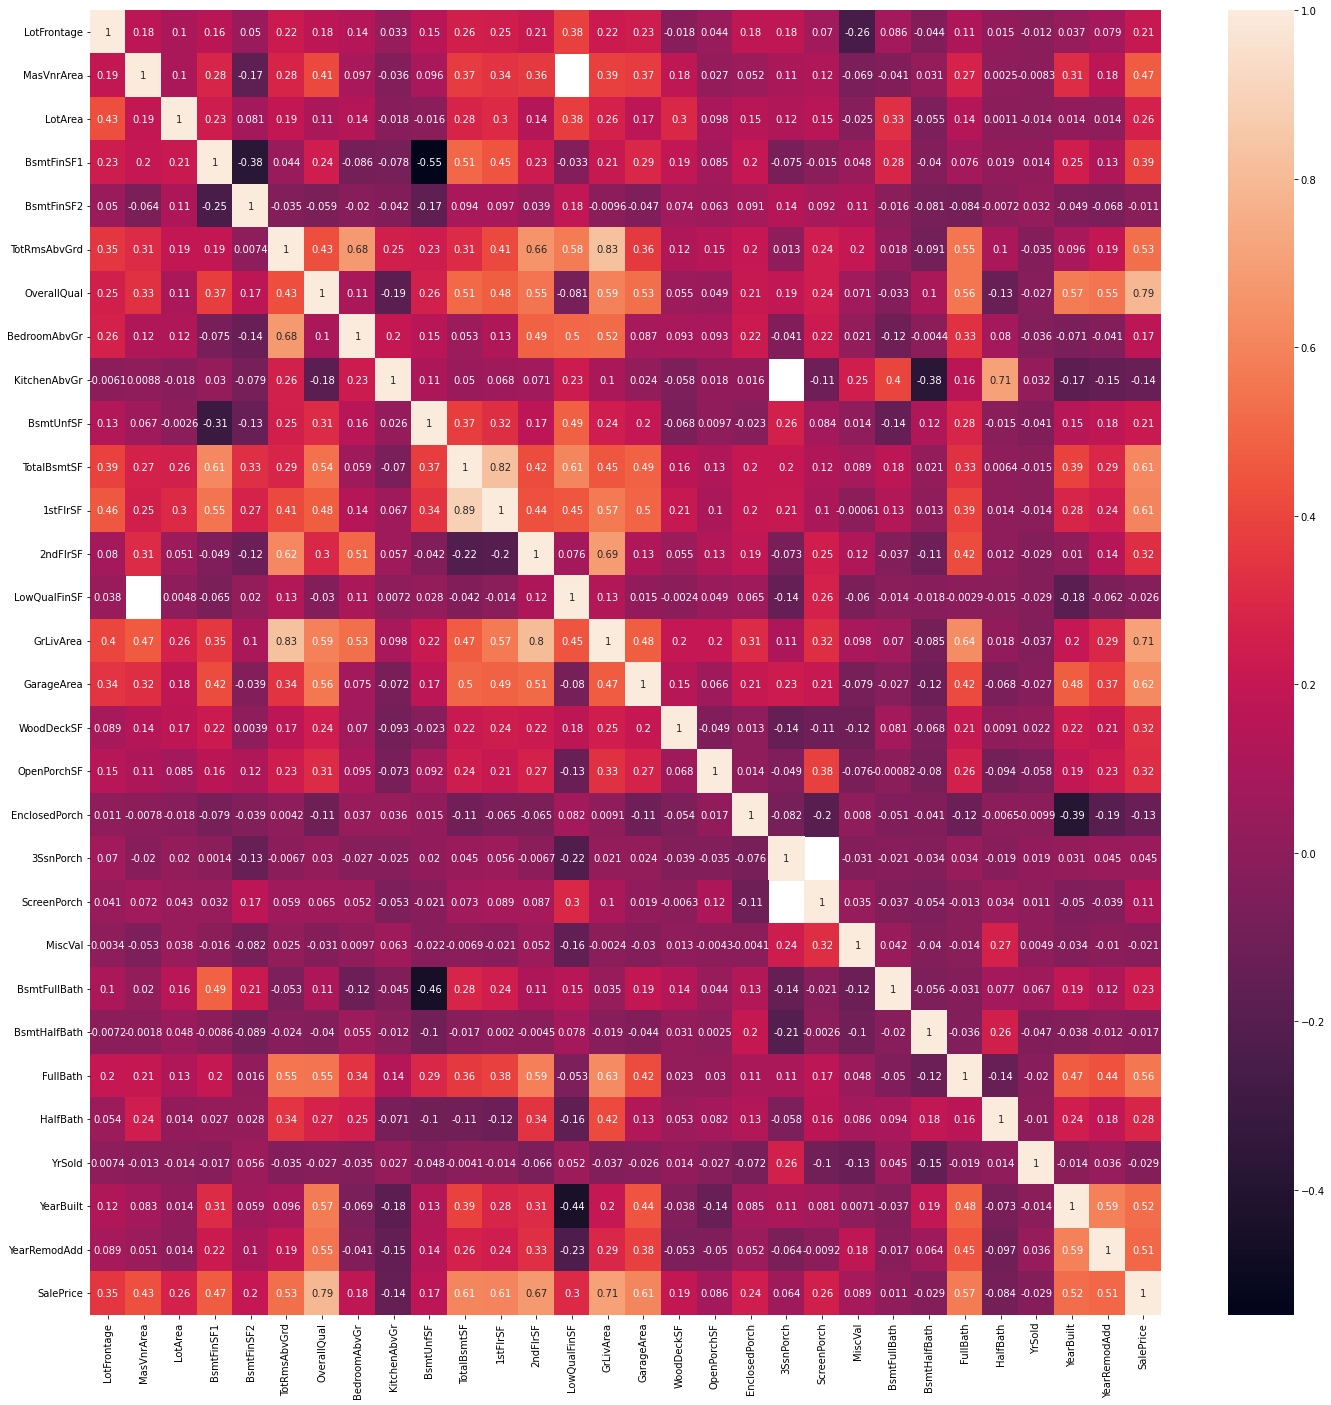

In [12]:
def clean_correlation(data):
  features_correlation = []
  for feature in data.columns:
    clean_data = data[data[feature] > 0]
    feature_corr = clean_data.corr().loc[:, feature]
    features_correlation.append(feature_corr)
  correlation_df = pd.concat(features_correlation, axis=1, ignore_index=True, keys=data.columns)
  correlation_df.columns = correlation_df.index
  return correlation_df

clean_correlation = clean_correlation(train_fill.loc[:,NUMERIC_FEATURES])
plt.figure(figsize=(24, 24))
sns.heatmap(clean_correlation, annot=True);

## Time based features

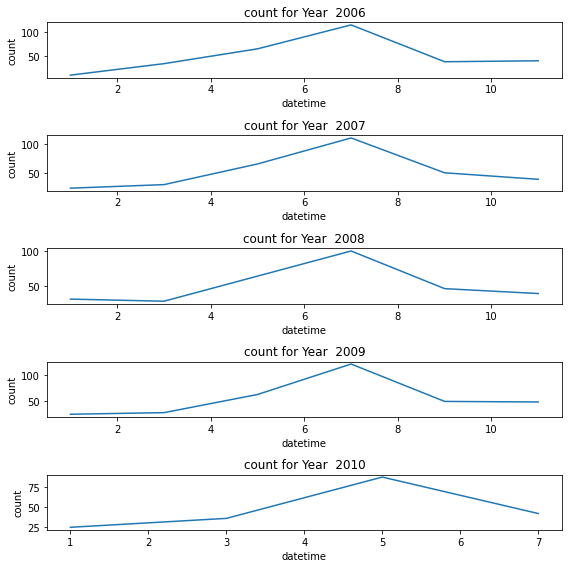

In [13]:
import datetime

train_fill['datetime'] = train_fill.apply(lambda r: pd.to_datetime(datetime.date(year=r['YrSold'], month=r['MoSold'], day=15)), axis=1 )
resample_data = train_fill.resample(rule="2M", on="datetime")['SalePrice'].aggregate(["count"])
plt.subplots(5,1, figsize=(8,8))
plot_index = 0


for year in resample_data.index.year.unique().sort_values():
  ts_data = resample_data[resample_data.index.year == year]
  for i, col in enumerate(resample_data.columns):
    plt.subplot(5, 1, plot_index+ 1)
    sns.lineplot(x=ts_data.index.month, y= ts_data[col])
    plt.title(f"{col} for Year  {year}")
    plot_index +=1
  
plt.tight_layout()

# Data processing







In [65]:
def one_hot_encoding(data, categorical_features):
  return pd.get_dummies(data=data.loc[:, categorical_features], columns=categorical_features)


def map_categorical_feature(data, feature, features_values):
  for val in features_values:
    feature_name = feature + "_" + val
    if feature_name not in data.columns:
      data[feature_name] = 0
  return data


def map_totRms(number_of_rooms):
  rooms_mapping = None
  if number_of_rooms <=3:
    rooms_mapping = 0
  if number_of_rooms ==4:
    rooms_mapping = 1
  elif number_of_rooms <=6:
    rooms_mapping = 2
  elif number_of_rooms <=9:
    rooms_mapping = 3
  else:
    rooms_mapping = 4
  return rooms_mapping


def data_pipeline(df):
  data = df.copy()
  data['GarageCars'] = data['GarageCars'].apply(lambda x: x if x <=3 else 3).astype(int)
  data['FullBath'] = data['FullBath'].apply(lambda x: x if x <=3 else 3).astype(int)
  data['Fireplaces'] = data['Fireplaces'].apply(lambda x: x if x <=3 else 3).astype(int)
  data['OverallCond'] = data['OverallCond'].map({1: "BelowAverage", 2: "BelowAverage", 3: "BelowAverage",
                                                 4:"BelowAverage", 5: "Average", 6: "AboveAverage", 7: "AboveAverage", 8: "AboveAverage", 9: "AboveAverage", 1: "AboveAverage"})
  data['TotRmsAbvGrd'] = data['TotRmsAbvGrd'].map(map_totRms)
  data['CentralAir'] = data['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)
  data["HeatingQC"] = data["HeatingQC"].map(quality_aggregate_mapping)
  data["FireplaceQu"] = data["FireplaceQu"].map(quality_aggregate_mapping)
  return data 

In [69]:
MODEL_NUMERIC_FEATURES = ["LotFrontage", "LotArea", "MasVnrArea", 'BsmtFinSF1', "TotRmsAbvGrd",'OverallQual',
                          "1stFlrSF", '2ndFlrSF','GrLivArea', 'GarageArea', "YearBuilt"]

BOOLEAN_FEATURES = ["CentralAir", "HeatingQC", "FireplaceQu"]

MODEL_CATEGORICAL_FEATURES = ['ExterQual', 'BsmtQual', 'KitchenQual',  'MSSubClass','GarageType',"GarageCars", "FullBath", "Fireplaces","Foundation","LandContour",
                              'BsmtExposure', 'MSZoning', "Neighborhood",'OverallCond', 'SaleCondition', "BsmtFinType1", "BldgType"]

train = data_pipeline(train_fill)


## PCA

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

CONTEXTS = ["Area"]

pca_features = []
for context in CONTEXTS: 
  context_columns = [col for col in train.loc[:, NUMERIC_FEATURES ].columns if context in col]
  context_features = train.loc[:, context_columns]
  scaler = MinMaxScaler()
  norm_data = scaler.fit_transform(context_features)
  pca_model = PCA(n_components=1)
  pca_feature = pca_model.fit_transform(norm_data)
  pca_features.append(pca_feature.flatten())


pca_features = pd.DataFrame(np.transpose(pca_features), columns=CONTEXTS)

# Training

## split to train test

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_features = one_hot_encoding(train, MODEL_CATEGORICAL_FEATURES)
train_features = pd.concat((train_features, train.loc[:, MODEL_NUMERIC_FEATURES], train.loc[:, BOOLEAN_FEATURES]), axis=1)
train_features = train_features.reindex(sorted(train_features.columns), axis=1)

train_X, validation_X, train_y, validation_y = train_test_split(train_features, train['SalePrice'], test_size=0.25)

## XGBoost

In [73]:
import xgboost 

model = xgboost.XGBRegressor(max_depth=1, booster="gbtree", subsample=0.7, n_estimators=200)

model.fit(train_X.values, train_y.values)
train_predictions = model.predict(train_X.values)

train_error = mean_absolute_error(train_y, train_predictions)
print(f"train error {train_error}")

model_predictions = model.predict(validation_X.values)

valiadtion_error = mean_absolute_error(validation_y, model_predictions)
print(f"valiadtion error {valiadtion_error}")


[09:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train error 16344.193022260273
valiadtion error 20020.70196917808


In [76]:
from sklearn.model_selection import cross_validate

model_cv = xgboost.XGBRegressor(max_depth=3, booster="gbtree", subsample=0.7, n_estimators=500, reg_alpha=50)

scores = cross_validate(model_cv,train_features, train['SalePrice'], cv=10, scoring='neg_mean_absolute_error')

print(f"Test results {scores['test_score']}, mean: {-np.mean(scores['test_score'])}")


[09:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## feature importance

In [75]:
def calculate_feature_importance(model, features):
  features_importance = pd.DataFrame({"Feature_name": features, "Importance": model.feature_importances_})
  features_importance['Feature'] = features_importance['Feature_name'].apply(lambda s: s.split('_')[0])
  features_importance = features_importance.groupby('Feature')['Importance'].sum().sort_values(ascending=False)
  return features_importance


features_importance = calculate_feature_importance(model, train_features.columns)
features_importance[0:20]

Feature
GarageCars       0.247497
OverallQual      0.211622
ExterQual        0.131106
BsmtQual         0.071268
Fireplaces       0.063748
GrLivArea        0.043316
YearBuilt        0.029508
Neighborhood     0.022992
1stFlrSF         0.019968
KitchenQual      0.018578
FullBath         0.016348
MSZoning         0.015673
CentralAir       0.015127
SaleCondition    0.014873
OverallCond      0.014823
LotArea          0.012123
BsmtFinSF1       0.011001
BsmtExposure     0.009644
GarageArea       0.009403
2ndFlrSF         0.008902
Name: Importance, dtype: float32

## Catboost

In [24]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00


In [25]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
train_fill = fill_missing_values(train_data)
train = data_pipeline(train_fill)

train_features = train.loc[:, MODEL_CATEGORICAL_FEATURES]


train_features = pd.concat((train_features, train.loc[:, MODEL_NUMERIC_FEATURES] ), axis=1)

In [29]:
model_catboost = CatBoostRegressor
model_cv = CatBoostRegressor(depth=3,iterations=5000, learning_rate=5e-2, bootstrap_type="MVS",
                             l2_leaf_reg=1e-3, cat_features=MODEL_CATEGORICAL_FEATURES, loss_function="MAE",
                             min_child_samples=50,subsample=0.8,
                             one_hot_max_size=13, verbose=0, random_strength=1, grow_policy="Depthwise")

scores = cross_val_score(model_cv,train_features, train['SalePrice'], cv=5, scoring='neg_mean_absolute_error')

print(scores)
-np.mean(scores)

[-14699.15391414 -16845.56373777 -15753.63163846 -13400.18990026
 -17230.53124418]


15585.81408696165

# Test prediction

In [77]:
model = xgboost.XGBRegressor(max_depth=3, booster="gbtree", subsample=0.7, n_estimators=500, reg_alpha=50)

train_features = one_hot_encoding(train, MODEL_CATEGORICAL_FEATURES)
train_features = pd.concat((train_features, train.loc[:, MODEL_NUMERIC_FEATURES], train.loc[:, BOOLEAN_FEATURES]), axis=1)
train_features = train_features.reindex(sorted(train_features.columns), axis=1)

model.fit(train_features.values, train['SalePrice'])

[09:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=500, reg_alpha=50, subsample=0.7)

In [78]:
test = fill_missing_values(test_data)

test = data_pipeline(test)

test_cat = one_hot_encoding(test, MODEL_CATEGORICAL_FEATURES)
test_data.loc[test_data['MSSubClass'] == 150]['MSSubClass'] = 160

test = pd.concat((test_cat, test.loc[:, MODEL_NUMERIC_FEATURES], test.loc[:, BOOLEAN_FEATURES]  ), axis=1)
test = test.reindex(sorted(test.columns), axis=1)
test = test.fillna(0)
test_predictions = model.predict(test.values)

In [79]:
test_predictions = pd.DataFrame({'Id': test_data['Id'], 'SalePrice':test_predictions})
test_predictions.to_csv("sample_submission.csv", index=False)

In [80]:
test_predictions

,Id,SalePrice
0,1461,129999.093750
1,1462,165871.468750
2,1463,181286.328125
3,1464,193242.812500
4,1465,185296.312500
...,...,...
1454,2915,82068.523438
1455,2916,80671.992188
1456,2917,155110.328125
1457,2918,119918.937500


In [ ]:
# out_categorical = list(set(CATEGORICAL_FEATURES) - set(MODEL_CATEGORICAL_FEATURES))
# out_numeric = list(set(NUMERIC_FEATURES) - set(MODEL_NUMERIC_FEATURES))

# train_features = one_hot_encoding(train, out_categorical)
# train_features = pd.concat((train_features, train.loc[:, out_numeric] ), axis=1)
# train_features.drop("SalePrice", inplace=True, axis=1)
# train_X, validation_X, train_y, validation_y = train_test_split(train_features, train['SalePrice'], test_size=0.25)
# model = xgboost.XGBRegressor(max_depth=2, booster="gbtree", subsample=0.7, n_estimators=500, reg_lambda=10)

# model.fit(train_X.values, train_y.values)
# train_predictions = model.predict(train_X.values)

# train_error = mean_absolute_error(train_y, train_predictions)
# print(f"train error {train_error}")

# model_predictions = model.predict(validation_X.values)

# valiadtion_error = mean_absolute_error(validation_y, model_predictions)
# print(f"valiadtion error {valiadtion_error}")
